# Прогнозирование пассажиропотока

Необходимо проанализировать данные о количестве авиапассажиров, построить модель скользящего среднего (MA) и модель ARIMA, автоматически подобрать параметры для ARIMA с помощью библиотеки auto_arima, а затем сравнить прогнозы обеих моделей.

## 1. Подготовка данных

In [ ]:
!pip install pmdarima

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
data = sns.load_dataset('flights')
data.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [ ]:
# превратим дату в индекс, лишние столбцы удалим
data['month'] = pd.to_datetime(data['month'], format='%b').dt.month
data['date']=pd.to_datetime(data[['year', 'month']].assign(day=1))
data = data.drop(['year', 'month'], axis = 1)
data = data.set_index('date')
data.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
# проверим, что индекс у нас имеет тип даты
data.index[:5]

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01'],
              dtype='datetime64[ns]', name='date', freq=None)

## 2. Скользящая средняя

In [ ]:
# построим скользящее среднее с окном 12 месяцев
data['moving_average'] = data['passengers'].rolling(window = 12).mean()

# добавим прогноз
last_date = data.iloc[[-1]].index + pd.DateOffset(months=1)
data = pd.concat([data, pd.DataFrame(index = last_date)])

data['moving_average'] = data['moving_average'].shift(1)

In [ ]:
data.tail()

,passengers,moving_average
date,,
1960-09-01,508.0,463.333333
1960-10-01,461.0,467.083333
1960-11-01,390.0,471.583333
1960-12-01,432.0,473.916667
1961-01-01,NaN,476.166667


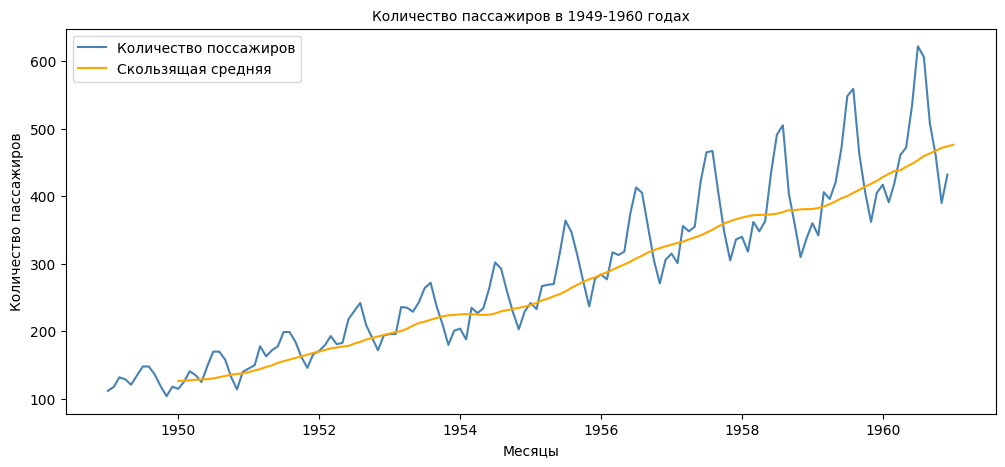

In [ ]:
# посмотрим на результат на графике
plt.figure(figsize = (12,5))
plt.plot(data['passengers'], label = 'Количество поссажиров', color = 'steelblue')
plt.plot(data['moving_average'], label = 'Скользящая средняя', color = 'orange')
plt.legend(title = '', loc = 'upper left', fontsize = 10)
plt.ylabel('Количество пассажиров', fontsize = 10)
plt.xlabel('Месяцы', fontsize = 10)
plt.title('Количество пассажиров в 1949-1960 годах', fontsize = 10)

plt.show()

## 2. ARIMA

In [ ]:
# обучающая выборка
train = data[:'1959-12-01']['passengers']
# тестовая выборка
test = data['1960-01-01':'1960-12-01']['passengers']

In [ ]:
# поиск параметров
parameter_search = auto_arima(train, seasonal=False, stepwise=True, trace=True, suppress_warnings=True)
print(parameter_search.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1218.683, Time=4.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1277.589, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1268.313, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1264.738, Time=1.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1276.259, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=6.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1258.440, Time=1.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=8.70 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1225.563, Time=2.72 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 36.16

In [ ]:
# создадим объект лучшей модели
model = ARIMA(train, order=(2, 1, 2))
result = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


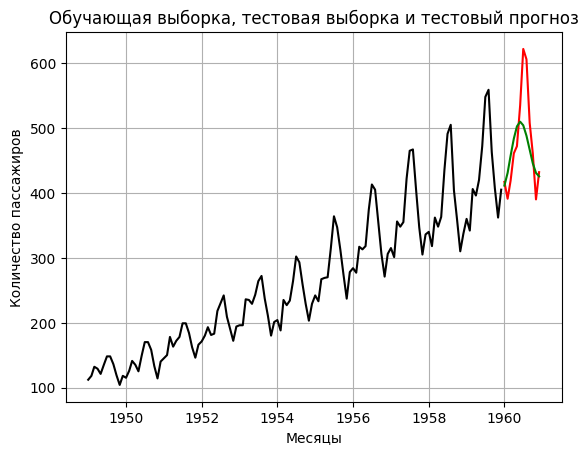

In [ ]:
# тестовый прогнозный период
start = len(train)
end = len(train) + len(test) - 1
predictions = result.predict(start, end)
# график
plt.plot(train, color = 'black')
plt.plot(test, color = 'red')
plt.plot(predictions, color = 'green')
plt.title('Обучающая выборка, тестовая выборка и тестовый прогноз')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')
plt.grid()

plt.show()

In [ ]:
# MSE
print(mean_squared_error(test, predictions))

# RMSE
print(np.sqrt(mean_squared_error(test, predictions)))

3049.561964547518
55.22283915688796


In [ ]:
# прогнозный на 12 месяцев
start = len(data)
end = (len(data) - 1) + 12
forecast = result.predict(start, end)
forecast[-12:]

,predicted_mean
1961-02-01,443.622942
1961-03-01,461.008138
1961-04-01,477.711231
1961-05-01,489.381504
1961-06-01,493.300973
1961-07-01,488.984866
1961-08-01,478.151561
1961-09-01,464.114419
1961-10-01,450.796531
1961-11-01,441.654469


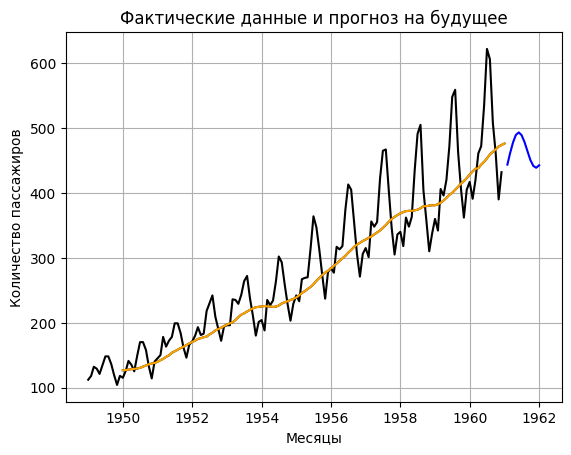

In [ ]:
# выведем три кривые (фактические данные, скользящая средняя и прогноз на будущее)
plt.plot(data, color = 'black')
plt.plot(forecast, color = 'blue')
plt.plot(data['moving_average'], color = 'orange')

# заголовок и подписи к осям
plt.title('Фактические данные и прогноз на будущее')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')
plt.grid()
plt.show()

**Вывод:**

Скользящая средняя и ARIMA не очень точно прогнозируют ряд с сезонными колебаниями. Лучше использовать SARIMAX.

## 4. SARIMAX

In [ ]:
train = data[:'1959-12']['passengers']
test = data['1960-01':'1960-12-01']['passengers']

parameter_search = auto_arima(train, start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 12, start_P = 0, seasonal = True,
                         d = None, D = 1, trace = True, error_action ='ignore', suppress_warnings = True,  stepwise = True)           #

print(parameter_search.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=907.364, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.37 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=1.23 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.41 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.10 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.32 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=0.55 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.19 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=0.43 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   :

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


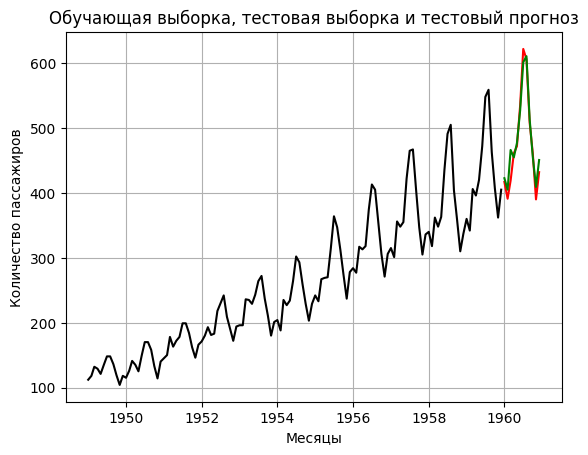

In [ ]:
model = SARIMAX(train,
                order = (3, 0, 0),
                seasonal_order = (0, 1, 0, 12))

result = model.fit()
start = len(train)
end = len(train) + len(test) - 1

predictions = result.predict(start, end)

# график
plt.plot(train, color = 'black')
plt.plot(test, color = 'red')
plt.plot(predictions, color = 'green')
plt.title('Обучающая выборка, тестовая выборка и тестовый прогноз')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')
plt.grid()

plt.show()

In [ ]:
print(mean_squared_error(test, predictions))
print(np.sqrt(mean_squared_error(test, predictions)))

317.39565432961956
17.81560143047715


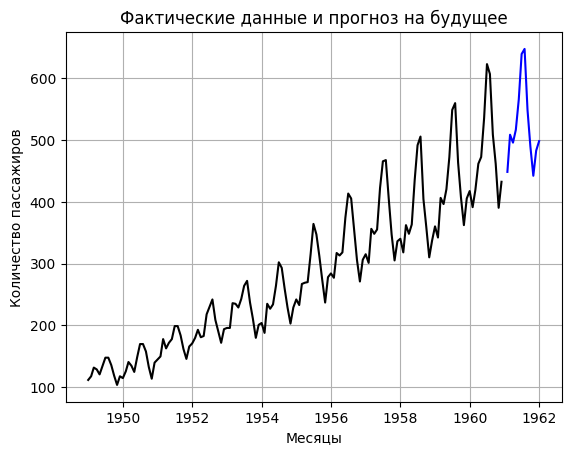

In [ ]:
# прогноз
start = len(data['passengers'])
end = (len(data['passengers']) - 1) + 12
forecast = result.predict(start, end)

# график
plt.plot(data['passengers'], color = 'black')
plt.plot(forecast, color = 'blue')

# заголовок и подписи к осям
plt.title('Фактические данные и прогноз на будущее')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')
plt.grid()

plt.show()

**Вывод:**

Из всех моделей, которые мы провелими, лучшие результаты показала модель на основе SARIMAX, поскольку она учитывает сезонные колебания и тренд.